## 통신사 고객 해지 기간 예측을 위한 생존분석

### 생존분석(Survival Analysis) 개념 설명

생존분석은 시간에 따라 발생하는 이벤트(예: 고객 해지)를 분석하는 통계 기법입니다. 이 기법은 주로 의료 분야에서 환자의 생존 시간을 분석하는 데 사용되지만, 비즈니스 분야에서도 고객 이탈 예측, 기계 고장 예측 등 다양한 응용 사례가 있습니다.

고객의 해지 여부와 해지 시점을 예측함으로써, 고객의 생애 가치(Lifetime Value, LTV)를 계산하고, 적절한 마케팅 전략을 세울 수 있습니다. 생존분석은 이러한 문제를 해결하는 데 매우 유용한 도구입니다. 

1. **생존 함수(Survival Function)**: 특정 시점까지 생존할 확률을 나타냅니다.
2. **위험 함수(Hazard Function)**: 특정 시점에서 이벤트(예: 해지)가 발생할 위험률을 나타냅니다.
3. **검열(Censoring)**: 관찰 기간 동안 이벤트가 발생하지 않은 경우를 의미합니다. 예를 들어, 고객이 아직 해지하지 않은 상태에서 데이터 수집이 종료된 경우입니다.

### 데이터 생성 및 전처리

먼저, 가상의 고객 데이터를 생성하고 전처리합니다. 어떤 형태의 데이터가 필요한지 눈여겨 봐주세요.

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)
num_samples = 50000
customer_id = np.arange(1, num_samples + 1)
bundle_subscription = np.random.binomial(1, 0.5, num_samples)
subscription_duration_bundle = np.round(np.random.exponential(scale=500, size=num_samples))  # 번들 구독자의 경우 더 김
subscription_duration_no_bundle = np.round(np.random.exponential(scale=300, size=num_samples))  # 비구독자의 경우 더 짧음
subscription_duration = np.where(bundle_subscription == 1, subscription_duration_bundle, subscription_duration_no_bundle)
churn_prob_bundle = 0.2  # 번들 구독자의 이탈 확률 낮음
churn_prob_no_bundle = 0.4  # 비구독자의 이탈 확률 높음
churn = np.where(bundle_subscription == 1, 
                 np.random.binomial(1, churn_prob_bundle, num_samples),
                 np.random.binomial(1, churn_prob_no_bundle, num_samples))
promotion_applied = np.random.binomial(1, 0.4, num_samples)
feature_1 = np.round(np.random.normal(50, 10, num_samples))
feature_2 = np.round(np.random.normal(30, 5, num_samples))
data = pd.DataFrame({
    'CustomerID': customer_id,
    'SubscriptionDuration': subscription_duration,
    'Churn': churn,
    'BundleSubscription': bundle_subscription,
    'PromotionApplied': promotion_applied,
    'Feature1': feature_1,
    'Feature2': feature_2
})

data.head()

,CustomerID,SubscriptionDuration,Churn,BundleSubscription,PromotionApplied,Feature1,Feature2
0,1,261.0,0,0,1,49.0,31.0
1,2,341.0,0,1,0,39.0,29.0
2,3,109.0,0,1,0,47.0,23.0
3,4,667.0,0,1,1,57.0,35.0
4,5,136.0,0,0,0,45.0,27.0



### 생존분석 모델 구축

이제 생존분석 모델을 구축합니다. 여기서는 Cox 비례 위험 모델(Cox Proportional Hazards Model)을 사용합니다. 이 모델은 시간에 따라 변하지 않는 위험 비율을 가정하여, 여러 변수의 영향을 분석할 수 있습니다.


In [2]:
# lifelines 패키지가 없을 경우 설치합니다
# !pip install lifelines

In [3]:
from lifelines import CoxPHFitter

# 모델 훈련
cph = CoxPHFitter()
cph.fit(data[['SubscriptionDuration', 'Churn', 'BundleSubscription', 'PromotionApplied', 'Feature1', 'Feature2']], 
        duration_col='SubscriptionDuration', event_col='Churn')

# 모델 요약
display(cph.summary)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
BundleSubscription,-1.195848,0.302447,0.017761,-1.230660,-1.161036,0.292100,0.313161,0.0,-67.328246,0.000000,inf
PromotionApplied,-0.016574,0.983563,0.016569,-0.049049,0.015901,0.952134,1.016028,0.0,-1.000278,0.317176,1.656644
Feature1,-0.000060,0.999940,0.000809,-0.001647,0.001526,0.998355,1.001527,0.0,-0.074376,0.940711,0.088176
Feature2,0.001339,1.001340,0.001618,-0.001832,0.004510,0.998170,1.004520,0.0,0.827814,0.407776,1.294151



### 결과 해석

모델의 결과를 해석합니다. CoxPHFitter의 `summary`는 각 변수의 회귀 계수와 p-value를 제공합니다. 이를 통해 각 변수의 해지에 대한 영향을 평가할 수 있습니다.

- **회귀 계수(Coefficient)**: 양수이면 해당 변수의 값이 증가할수록 해지 위험이 증가함을 의미합니다. 음수이면 해지 위험이 감소함을 의미합니다.
- **p-value**: 변수의 유의성을 평가합니다. 일반적으로 p-value가 0.05 이하이면 해당 변수가 유의미하다고 판단합니다.

### 예측 및 시각화

마지막으로, 모델을 사용하여 예측을 수행하고 결과를 시각화합니다.


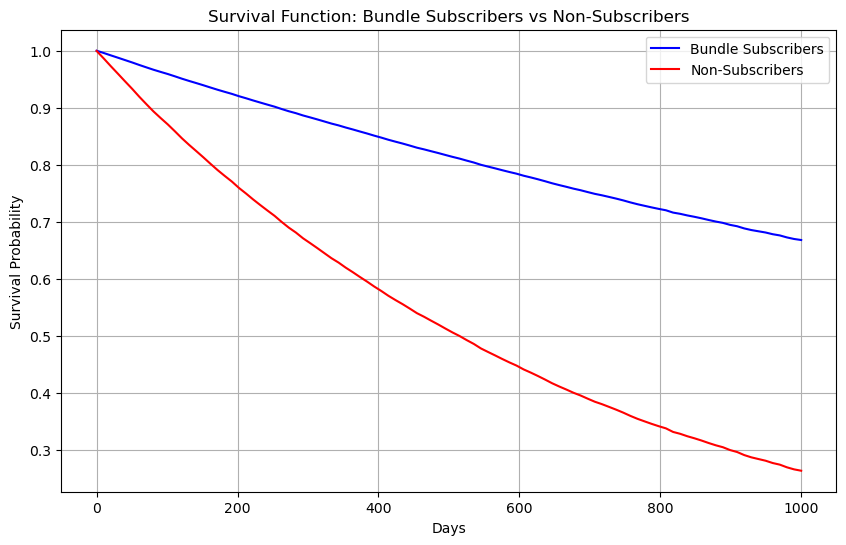

In [4]:
import matplotlib.pyplot as plt

# 평균 데이터 생성
average_data = data[['PromotionApplied', 'Feature1', 'Feature2']].mean().to_frame().T
bundle_data = average_data.copy()
bundle_data['BundleSubscription'] = 1
no_bundle_data = average_data.copy()
no_bundle_data['BundleSubscription'] = 0

# 생존 함수 예측
times = np.linspace(0, 1000, 100)
pred_bundle = cph.predict_survival_function(bundle_data, times=times)
pred_no_bundle = cph.predict_survival_function(no_bundle_data, times=times)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(pred_bundle.index, pred_bundle.values.flatten(), label='Bundle Subscribers', color='blue')
plt.plot(pred_no_bundle.index, pred_no_bundle.values.flatten(), label='Non-Subscribers', color='red')
plt.title('Survival Function: Bundle Subscribers vs Non-Subscribers')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# 중간 생존 시간 계산
median_bundle = cph.predict_median(bundle_data)
median_no_bundle = cph.predict_median(no_bundle_data)

print(f"번들 가입자의 중간 생존 시간: {median_bundle:.0f}일")
print(f"비가입자의 중간 생존 시간: {median_no_bundle:.0f}일")
print(f"즉, 번들 가입자는 비가입자보다 평균적으로 {median_bundle - median_no_bundle:.0f}일 더 오래 서비스를 이용합니다.")

# 특정 시점에서의 생존 확률 계산 (예: 1년 후)
survival_prob_bundle = cph.predict_survival_function(bundle_data, times=[365]).iloc[0, 0]
survival_prob_no_bundle = cph.predict_survival_function(no_bundle_data, times=[365]).iloc[0, 0]

print(f"\n1년 후 고객 유지율:")
print(f"번들 가입자: {survival_prob_bundle:.1%}")
print(f"비가입자: {survival_prob_no_bundle:.1%}")
print(f"차이: {survival_prob_bundle - survival_prob_no_bundle:.1%}")

번들 가입자의 중간 생존 시간: 1724일
비가입자의 중간 생존 시간: 515일
즉, 번들 가입자는 비가입자보다 평균적으로 1209일 더 오래 서비스를 이용합니다.

1년 후 고객 유지율:
번들 가입자: 86.1%
비가입자: 61.0%
차이: 25.1%



### 분석을 통한 의사결정

생존분석을 통해 얻은 결과는 다양한 비즈니스 의사결정에 활용될 수 있습니다.

1. **고객 세분화**: 단기간 내 해지 위험이 높은 고객 그룹을 식별하여, 이들에게 맞춤형 프로모션이나 혜택을 제공함으로써 해지를 방지할 수 있습니다.
2. **마케팅 전략**: 특정 프로모션이나 결합 상품이 해지 위험에 미치는 영향을 분석하여, 효과적인 마케팅 전략을 수립할 수 있습니다.
3. **고객 생애 가치(LTV) 계산**: 고객의 예상 생존 기간을 기반으로 LTV를 계산하여, 고객 확보 및 유지에 대한 투자 결정을 최적화할 수 있습니다.
4. **서비스 개선**: 단기간 내 해지 위험이 높은 고객의 특성을 분석하여, 서비스 품질을 개선하고 고객 만족도를 높일 수 있습니다.